<a href="https://colab.research.google.com/github/David121189/GANs-for-agriculture/blob/main/GansDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import cv2 

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

In [ ]:
PATH = '/content/drive/MyDrive/Dataset_PG/'
print(PATH)

/content/drive/MyDrive/Dataset_PG/


In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
number_of_filters = 4
LAMBDA = 100
EPOCHS = 100

In [ ]:
def plot_losses(g_loss, d_loss, epoch, dataset):
    """Plot the losses each epoc during training."""
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig('results/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig('results/loss_tracking.png')
        plt.close()

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return tensor

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2

  real_image = image[ :,w:,:]
  input_image = image[:,:w,:]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image 

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'trainf/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+'testf/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

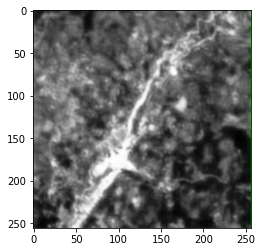

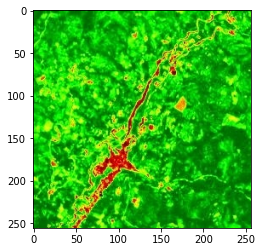

In [ ]:
inp, re = load(PATH+'trainf/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255, cmap='Greens')

In [ ]:
print(test_dataset)

<BatchDataset shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>


In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
class ResidualBlock(tf.keras.Model):
    
    def __init__(self, filters, size):
        super(ResidualBlock, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters,
                                            (size, size),
                                            padding='same',
                                            kernel_initializer='he_normal',
                                            use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters,
                                            (size, size),
                                            padding='same',
                                            kernel_initializer='he_normal',
                                            use_bias=False)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
  
    def call(self, x, training):
        y = self.conv1(x)
        y = self.batchnorm1(y, training=training)
        y = tf.nn.relu(y)
        y = self.conv2(y)
        y = self.batchnorm2(y, training=training)
        y = tf.math.add(x, y)
        return y

class Generator(tf.keras.Model):
    
    def __init__(self, noise=False):
        super(Generator, self).__init__()
        self.noise_inputs = noise
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.init = tf.keras.layers.Conv2D(64,
                                           (7, 7),
                                           padding='same',
                                           kernel_initializer=initializer,
                                           use_bias=False)
        self.batchnorm = tf.keras.layers.BatchNormalization()
        
        self.down1 = downsample(128, 4)
        self.down2 = downsample(256, 4)
        
        self.res1 = ResidualBlock(256, 3)
        self.res2 = ResidualBlock(256, 3)
        self.res3 = ResidualBlock(256, 3)
        self.res4 = ResidualBlock(256, 3)
        self.res5 = ResidualBlock(256, 3)
        self.res6 = ResidualBlock(256, 3)
        self.res7 = ResidualBlock(256, 3)
        self.res8 = ResidualBlock(256, 3)
        self.res9 = ResidualBlock(256, 3)

        self.up1 = upsample(128, 4)
        self.up2 = upsample(64, 4)

        self.last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS,
                                           (7, 7),
                                           padding='same',
                                           kernel_initializer=initializer)
  

    def call(self, x, training = False):
        # x shape == (bs, 256, 256, 3)
        if self.noise_inputs:
            z = tf.random_normal(shape=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1])
            x = tf.concat([x, z], axis=-1) # (bs, 256, 256, 4)
        
        x1 = self.init(x) # (bs, 256, 256, 64)
        x1 = self.batchnorm(x1)
        x1 = tf.nn.relu(x1)
        
        x2 = self.down1(x1) # (bs, 128, 128, 128)
        x3 = self.down2(x2) # (bs, 64, 64, 256)
        
        x4 = self.res1(x3)
        x4 = self.res2(x4)
        x4 = self.res3(x4)
        x4 = self.res4(x4)
        x4 = self.res5(x4)
        x4 = self.res6(x4)
        x4 = self.res7(x4)
        x4 = self.res8(x4)
        x4 = self.res9(x4)
        
        x5 = self.up1(x4, None) # (bs, 128, 128, 128)
        x6 = self.up2(x5, None) # (bs, 256, 256, 64)

        x7 = self.last(x6) # (bs, 256, 256, 3)
        x7 = tf.nn.tanh(x7)

        return x7

In [ ]:
class Generator(tf.keras.Model):
    """docstring for Generator_."""
    def __init__(self,):
        super(Generator, self).__init__()
        self.downsample = [downsample(64, 4, apply_batchnorm=False),
                           downsample(128, 4),  # (bs, 64, 64, 128)
                           downsample(256, 4),  # (bs, 32, 32, 256)
                           downsample(512, 4),  # (bs, 16, 16, 512)
                           downsample(512, 4),  # (bs, 8, 8, 512)
                           downsample(512, 4),  # (bs, 4, 4, 512)
                           downsample(512, 4),  # (bs, 2, 2, 512)
                           downsample(512, 4)]  # (bs, 1, 1, 512)

        self.upsample = [upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
                         upsample(512, 4),  # (bs, 16, 16, 1024)
                         upsample(256, 4),  # (bs, 32, 32, 512)
                         upsample(128, 4),  # (bs, 64, 64, 256)
                         upsample(64, 4)]  # (bs, 128, 128, 128)

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh') # (bs, 256, 256, 3)
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs, training=False):
        """Define the forward pass."""
        x = inputs
        # Downsampling through the model
        skips = []
        for down in self.downsample:
          x = down(x)
          skips.append(x)
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(self.upsample, skips):
          x = up(x)
          x = self.concat([x, skip])
        return self.last(x)

SyntaxError: ignored

In [ ]:
unet = Generator()
unet.model.summary()

AttributeError: ignored

In [ ]:
class Generator(tf.keras.Model):
    
    def __init__(self, noise=False):
        super(Generator, self).__init__()
        self.noise_inputs = noise
        initializer = tf.random_normal_initializer(0., 0.02)
    
        self.down1 = downsample(64, 4, apply_batchnorm=False)
        self.down2 = downsample(128, 4)
        self.down3 = downsample(256, 4)
        self.down4 = downsample(512, 4)
        self.down5 = downsample(512, 4)
        self.down6 = downsample(512, 4)
        self.down7 = downsample(512, 4)
        self.down8 = downsample(512, 4)

        self.up1 = upsample(512, 4, apply_dropout=True)
        self.up2 = upsample(512, 4, apply_dropout=True)
        self.up3 = upsample(512, 4, apply_dropout=True)
        self.up4 = upsample(512, 4)
        self.up5 = upsample(256, 4)
        self.up6 = upsample(128, 4)
        self.up7 = upsample(64, 4)

        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                                    (4, 4),
                                                    strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer)
  

    def call(self, x, training = False):
        # x shape == (bs, 256, 256, 3)
        if self.noise_inputs:
            z = tf.random_normal(shape=[BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1])
            x = tf.concat([x, z], axis=-1) # (bs, 256, 256, 4)
        
        x1 = self.down1(x) # (bs, 128, 128, 64)
        x2 = self.down2(x1) # (bs, 64, 64, 128)
        x3 = self.down3(x2) # (bs, 32, 32, 256)
        x4 = self.down4(x3) # (bs, 16, 16, 512)
        x5 = self.down5(x4) # (bs, 8, 8, 512)
        x6 = self.down6(x5) # (bs, 4, 4, 512)
        x7 = self.down7(x6) # (bs, 2, 2, 512)
        
        x8 = self.down8(x7) # (bs, 1, 1, 512)

        x9 = self.up1(x8, x7) # (bs, 2, 2, 1024)
        x10 = self.up2(x9, x6) # (bs, 4, 4, 1024)
        x11 = self.up3(x10, x5) # (bs, 8, 8, 1024)
        x12 = self.up4(x11, x4) # (bs, 16, 16, 1024)
        x13 = self.up5(x12, x3) # (bs, 32, 32, 512)
        x14 = self.up6(x13, x2) # (bs, 64, 64, 256)
        x15 = self.up7(x14, x1) # (bs, 128, 128, 128)

        x16 = self.last(x15) # (bs, 256, 256, 3)
        x16 = tf.nn.tanh(x16)

        return x16

In [ ]:
def conv2d(filters: int):
    initializer = tf.random_normal_initializer(0., 0.02)
    return Conv2D(filters=filters,
                  kernel_size=(2, 2),
                  padding='same', kernel_initializer=initializer, use_bias=False)


def conv2dtranspose(filters: int):
    initializer = tf.random_normal_initializer(0., 0.02)
    return Conv2DTranspose(filters=filters,
                           kernel_size=(2, 2),
                           strides=(2, 2),
                           padding='same', kernel_initializer=initializer, use_bias=False)


def Generator():
    model_input = tf.keras.layers.Input(shape=[256, 256, 3])

    x00 = conv2d(filters=int(16 * number_of_filters))(model_input)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU(0.01)(x00)
    x00 = Dropout(0.2)(x00)
    x00 = conv2d(filters=int(16 * number_of_filters))(x00)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU(0.01)(x00)
    x00 = Dropout(0.2)(x00)
    p0 = MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = conv2d(filters=int(32 * number_of_filters))(p0)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU(0.01)(x10)
    x10 = Dropout(0.2)(x10)
    x10 = conv2d(filters=int(32 * number_of_filters))(x10)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU(0.01)(x10)
    x10 = Dropout(0.2)(x10)
    p1 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = conv2dtranspose(int(16 * number_of_filters))(x10)
    x01 = concatenate([x00, x01])
    x01 = conv2d(filters=int(16 * number_of_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU(0.01)(x01)
    x01 = conv2d(filters=int(16 * number_of_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU(0.01)(x01)
    x01 = Dropout(0.2)(x01)

    x20 = conv2d(filters=int(64 * number_of_filters))(p1)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU(0.01)(x20)
    x20 = Dropout(0.2)(x20)
    x20 = conv2d(filters=int(64 * number_of_filters))(x20)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU(0.01)(x20)
    x20 = Dropout(0.2)(x20)
    p2 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = conv2dtranspose(int(16 * number_of_filters))(x20)
    x11 = concatenate([x10, x11])
    x11 = conv2d(filters=int(16 * number_of_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU(0.01)(x11)
    x11 = conv2d(filters=int(16 * number_of_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU(0.01)(x11)
    x11 = Dropout(0.2)(x11)

    x02 = conv2dtranspose(int(16 * number_of_filters))(x11)
    x02 = concatenate([x00, x01, x02])
    x02 = conv2d(filters=int(16 * number_of_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU(0.01)(x02)
    x02 = conv2d(filters=int(16 * number_of_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU(0.01)(x02)
    x02 = Dropout(0.2)(x02)

    x30 = conv2d(filters=int(128 * number_of_filters))(p2)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU(0.01)(x30)
    x30 = Dropout(0.2)(x30)
    x30 = conv2d(filters=int(128 * number_of_filters))(x30)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU(0.01)(x30)
    x30 = Dropout(0.2)(x30)
    p3 = MaxPooling2D(pool_size=(2, 2))(x30)

    x21 = conv2dtranspose(int(16 * number_of_filters))(x30)
    x21 = concatenate([x20, x21])
    x21 = conv2d(filters=int(16 * number_of_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU(0.01)(x21)
    x21 = conv2d(filters=int(16 * number_of_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU(0.01)(x21)
    x21 = Dropout(0.2)(x21)

    x12 = conv2dtranspose(int(16 * number_of_filters))(x21)
    x12 = concatenate([x10, x11, x12])
    x12 = conv2d(filters=int(16 * number_of_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU(0.01)(x12)
    x12 = conv2d(filters=int(16 * number_of_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU(0.01)(x12)
    x12 = Dropout(0.2)(x12)

    x03 = conv2dtranspose(int(16 * number_of_filters))(x12)
    x03 = concatenate([x00, x01, x02, x03])
    x03 = conv2d(filters=int(16 * number_of_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU(0.01)(x03)
    x03 = conv2d(filters=int(16 * number_of_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU(0.01)(x03)
    x03 = Dropout(0.2)(x03)

    m = conv2d(filters=int(256 * number_of_filters))(p3)
    m = BatchNormalization()(m)
    m = LeakyReLU(0.01)(m)
    m = conv2d(filters=int(256 * number_of_filters))(m)
    m = BatchNormalization()(m)
    m = LeakyReLU(0.01)(m)
    m = Dropout(0.2)(m)

    x31 = conv2dtranspose(int(128 * number_of_filters))(m)
    x31 = concatenate([x31, x30])
    x31 = conv2d(filters=int(128 * number_of_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU(0.01)(x31)
    x31 = conv2d(filters=int(128 * number_of_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU(0.01)(x31)
    x31 = Dropout(0.2)(x31)

    x22 = conv2dtranspose(int(64 * number_of_filters))(x31)
    x22 = concatenate([x22, x20, x21])
    x22 = conv2d(filters=int(64 * number_of_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU(0.01)(x22)
    x22 = conv2d(filters=int(64 * number_of_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU(0.01)(x22)
    x22 = Dropout(0.2)(x22)

    x13 = conv2dtranspose(int(32 * number_of_filters))(x22)
    x13 = concatenate([x13, x10, x11, x12])
    x13 = conv2d(filters=int(32 * number_of_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU(0.01)(x13)
    x13 = conv2d(filters=int(32 * number_of_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU(0.01)(x13)
    x13 = Dropout(0.2)(x13)

    x04 = conv2dtranspose(int(16 * number_of_filters))(x13)
    x04 = concatenate([x04, x00, x01, x02, x03], axis=3)
    x04 = conv2d(filters=int(16 * number_of_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU(0.01)(x04)
    x04 = conv2d(filters=int(16 * number_of_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU(0.01)(x04)
    x04 = Dropout(0.2)(x04)

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    #strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh')
    
    x = last(x04)
    return tf.keras.Model(inputs= model_input, outputs=x)

In [ ]:
unetpp = Generator()
unetpp.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 256, 256, 64) 768         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 256, 256, 64) 256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_60 (LeakyReLU)      (None, 256, 256, 64) 0           batch_normalization_60[0][0]     
____________________________________________________________________________________________

In [ ]:
def conv2d(filters: int):
    initializer = tf.random_normal_initializer(0., 0.02)
    return Conv2D(filters=filters,
                  kernel_size=(2, 2),
                  padding='same', kernel_initializer=initializer, use_bias=False)


def conv2dtranspose(filters: int):
    initializer = tf.random_normal_initializer(0., 0.02)
    return Conv2DTranspose(filters=filters,
                           kernel_size=(2, 2),
                           strides=(2, 2),
                           padding='same', kernel_initializer=initializer, use_bias=False)


def Generator():
    model_input = tf.keras.layers.Input(shape=[256, 256, 3])

    x00 = conv2d(filters=int(16 * number_of_filters))(model_input)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU()(x00)
    x00 = Dropout(0.5)(x00)
    x00 = conv2d(filters=int(16 * number_of_filters))(x00)
    x00 = BatchNormalization()(x00)
    x00 = LeakyReLU()(x00)
    x00 = Dropout(0.5)(x00)
    p0 = MaxPooling2D(pool_size=(2, 2))(x00)

    x10 = conv2d(filters=int(32 * number_of_filters))(p0)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU()(x10)
    x10 = Dropout(0.5)(x10)
    x10 = conv2d(filters=int(32 * number_of_filters))(x10)
    x10 = BatchNormalization()(x10)
    x10 = LeakyReLU()(x10)
    x10 = Dropout(0.5)(x10)
    p1 = MaxPooling2D(pool_size=(2, 2))(x10)

    x01 = conv2dtranspose(int(16 * number_of_filters))(x10)
    x01 = concatenate([x00, x01])
    x01 = conv2d(filters=int(16 * number_of_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU()(x01)
    x01 = conv2d(filters=int(16 * number_of_filters))(x01)
    x01 = BatchNormalization()(x01)
    x01 = LeakyReLU()(x01)
    x01 = Dropout(0.5)(x01)

    x20 = conv2d(filters=int(64 * number_of_filters))(p1)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU()(x20)
    x20 = Dropout(0.5)(x20)
    x20 = conv2d(filters=int(64 * number_of_filters))(x20)
    x20 = BatchNormalization()(x20)
    x20 = LeakyReLU()(x20)
    x20 = Dropout(0.5)(x20)
    p2 = MaxPooling2D(pool_size=(2, 2))(x20)

    x11 = conv2dtranspose(int(16 * number_of_filters))(x20)
    x11 = concatenate([x10, x11])
    x11 = conv2d(filters=int(16 * number_of_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU()(x11)
    x11 = conv2d(filters=int(16 * number_of_filters))(x11)
    x11 = BatchNormalization()(x11)
    x11 = LeakyReLU()(x11)
    x11 = Dropout(0.5)(x11)

    x02 = conv2dtranspose(int(16 * number_of_filters))(x11)
    x02 = concatenate([x00, x01, x02])
    x02 = conv2d(filters=int(16 * number_of_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU()(x02)
    x02 = conv2d(filters=int(16 * number_of_filters))(x02)
    x02 = BatchNormalization()(x02)
    x02 = LeakyReLU()(x02)
    x02 = Dropout(0.5)(x02)

    x30 = conv2d(filters=int(128 * number_of_filters))(p2)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU()(x30)
    x30 = Dropout(0.5)(x30)
    x30 = conv2d(filters=int(128 * number_of_filters))(x30)
    x30 = BatchNormalization()(x30)
    x30 = LeakyReLU()(x30)
    x30 = Dropout(0.5)(x30)
    p3 = MaxPooling2D(pool_size=(2, 2))(x30)

    x21 = conv2dtranspose(int(16 * number_of_filters))(x30)
    x21 = concatenate([x20, x21])
    x21 = conv2d(filters=int(16 * number_of_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU()(x21)
    x21 = conv2d(filters=int(16 * number_of_filters))(x21)
    x21 = BatchNormalization()(x21)
    x21 = LeakyReLU()(x21)
    x21 = Dropout(0.5)(x21)

    x12 = conv2dtranspose(int(16 * number_of_filters))(x21)
    x12 = concatenate([x10, x11, x12])
    x12 = conv2d(filters=int(16 * number_of_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU()(x12)
    x12 = conv2d(filters=int(16 * number_of_filters))(x12)
    x12 = BatchNormalization()(x12)
    x12 = LeakyReLU()(x12)
    x12 = Dropout(0.5)(x12)

    x03 = conv2dtranspose(int(16 * number_of_filters))(x12)
    x03 = concatenate([x00, x01, x02, x03])
    x03 = conv2d(filters=int(16 * number_of_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU()(x03)
    x03 = conv2d(filters=int(16 * number_of_filters))(x03)
    x03 = BatchNormalization()(x03)
    x03 = LeakyReLU()(x03)
    x03 = Dropout(0.5)(x03)

    m = conv2d(filters=int(256 * number_of_filters))(p3)
    m = BatchNormalization()(m)
    m = LeakyReLU()(m)
    m = conv2d(filters=int(256 * number_of_filters))(m)
    m = BatchNormalization()(m)
    m = LeakyReLU()(m)
    m = Dropout(0.5)(m)

    x31 = conv2dtranspose(int(128 * number_of_filters))(m)
    x31 = concatenate([x31, x30])
    x31 = conv2d(filters=int(128 * number_of_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU()(x31)
    x31 = conv2d(filters=int(128 * number_of_filters))(x31)
    x31 = BatchNormalization()(x31)
    x31 = LeakyReLU()(x31)
    x31 = Dropout(0.5)(x31)

    x22 = conv2dtranspose(int(64 * number_of_filters))(x31)
    x22 = concatenate([x22, x20, x21])
    x22 = conv2d(filters=int(64 * number_of_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU()(x22)
    x22 = conv2d(filters=int(64 * number_of_filters))(x22)
    x22 = BatchNormalization()(x22)
    x22 = LeakyReLU()(x22)
    x22 = Dropout(0.5)(x22)

    x13 = conv2dtranspose(int(32 * number_of_filters))(x22)
    x13 = concatenate([x13, x10, x11, x12])
    x13 = conv2d(filters=int(32 * number_of_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU()(x13)
    x13 = conv2d(filters=int(32 * number_of_filters))(x13)
    x13 = BatchNormalization()(x13)
    x13 = LeakyReLU()(x13)
    x13 = Dropout(0.5)(x13)

    x04 = conv2dtranspose(int(16 * number_of_filters))(x13)
    x04 = concatenate([x04, x00, x01, x02, x03], axis=3)
    x04 = conv2d(filters=int(16 * number_of_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU()(x04)
    x04 = conv2d(filters=int(16 * number_of_filters))(x04)
    x04 = BatchNormalization()(x04)
    x04 = LeakyReLU()(x04)
    x04 = Dropout(0.5)(x04)

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    #strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh')
    
    x = last(x04)
    return tf.keras.Model(inputs= model_input, outputs=x)

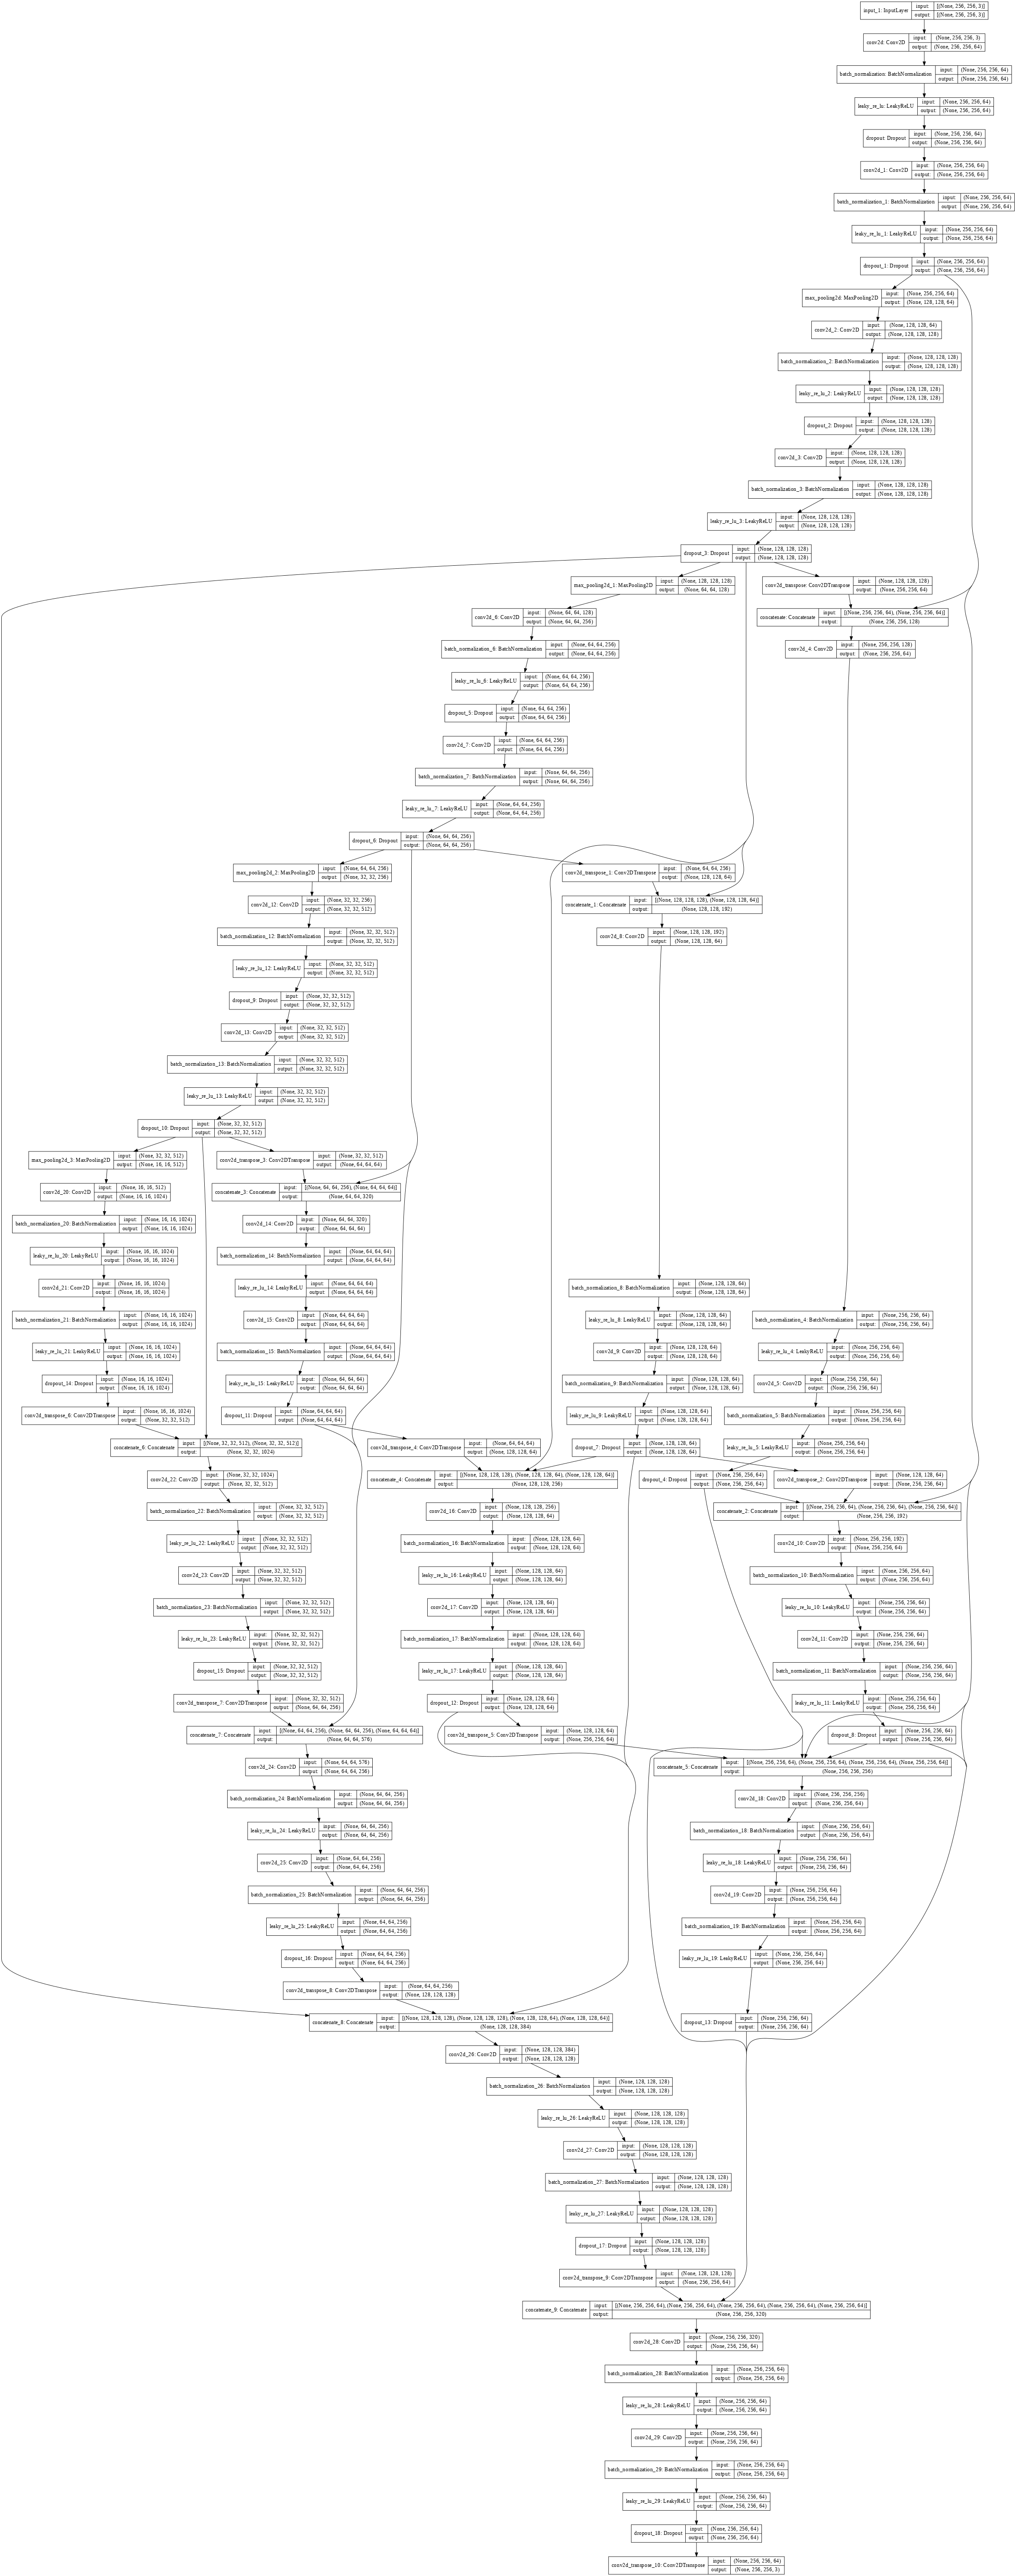

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

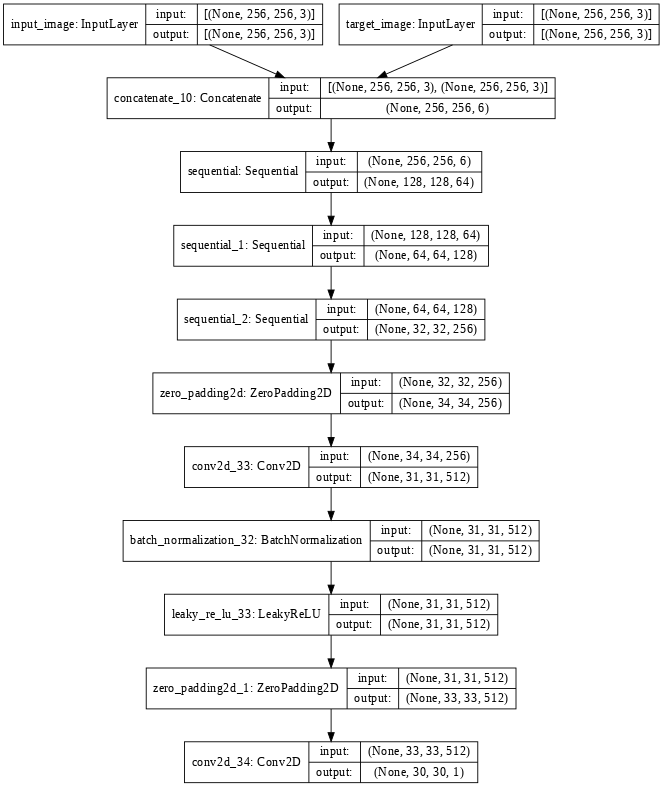

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './content/drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar, base_path='', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  """ Check the base path and make dir if needed."""

  if not os.path.exists(base_path):
    os.makedirs(base_path)
  #base_path = './content/driv/MyDrive/'
  
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  #image = tensor_to_image(prediction[0])
  #filename = 'NDVIP_{}.jpg'
  #cv2.imwrite(filename, image)
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()

In [ ]:
def plot_images(model, test_input, tar):
  os.chdir('/content/drive/MyDrive/imagenesfinales') 
  prediction = model(test_input, training=True)
  grid_row = prediction.shape[0]
  grid_col = 3
  f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*6, grid_row*6))
  for row in range(grid_row):
    ax = axarr if grid_row==1 else axarr[row]
    ax[0].imshow((test_input[row]+1)/2)
    ax[0].axis('off')
    image = tensor_to_image((test_input[row]+1)/2)
    filename = 'SAR'+str(row)+'.png'
    cv2.imwrite(filename, image)

    ax[1].imshow((tar[row]+1)/2)
    ax[1].axis('off') 
    image = tensor_to_image((tar[row]+1)/2)
    filename = 'NDVI'+str(row)+'.png'
    cv2.imwrite(filename, image)

    ax[2].imshow((prediction[row]+1)/2)
    ax[2].axis('off')
    image = tensor_to_image((prediction[row]+1)/2)
    filename = 'NDVIP'+str(row)+'.png'
    cv2.imwrite(filename, image) 
    plt.show()

In [ ]:
def ssim_image(model, test_input, tar):
    gen_output = model(test_input, training=True)
  
    ssim = tf.image.ssim(tar[0], gen_output[0], max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return ssim

    
def pnsr_image(model, test_input, tar):
    gen_output = model(test_input, training=True)
  
    pnsr = tf.image.psnr(tf.clip_by_value(tar[0], 0, 255),
                              tf.clip_by_value(gen_output[0], 0, 255), max_val=255)
  
    return pnsr

In [ ]:
def evaluate(model, test_input, tar):

    gen_output = model(test_input, training=True)
    avg_mse = tf.reduce_mean(tf.keras.losses.MSE(tar[0], gen_output[0]))
        
    return avg_mse

In [ ]:
@tf.function
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  g_loss_metric.update_state(gen_loss)
  d_loss_metric.update_state(disc_loss)


  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  # Create the metrics
  g_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    # Reset the metrics
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    counter = 0
    for input_image, target in dataset:
      train_step(input_image, target, g_loss_metric, d_loss_metric)
      counter += 1
      if counter > 100:
        break
    # Get the metric results
    g_mean_loss = g_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    g_loss_log.append([g_mean_loss])
    d_loss_log.append([d_mean_loss])
    # mean_accuracy = accuracy_metric.result()
    #
    print('Epoch: ', epoch)
    print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))

    if (epoch) % 10 == 0:
      for i, (inp, tar) in enumerate(test_dataset.take(5)):
        generate_images(generator, inp, tar, base_path='results/{}'.format(i), epoch=epoch)
        plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset')

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [ ]:
train(train_dataset, EPOCHS)

Epoch:  0
  loss (g) (d) (g+d):     8.343, 1.381, 9.724
Time taken for epoch 1 is 25.101438999176025 sec

Epoch:  1
  loss (g) (d) (g+d):     6.593, 1.218, 7.812
Time taken for epoch 2 is 15.94557785987854 sec

Epoch:  2
  loss (g) (d) (g+d):     6.188, 1.196, 7.384
Time taken for epoch 3 is 15.876147747039795 sec

Epoch:  3
  loss (g) (d) (g+d):     6.265, 1.206, 7.471
Time taken for epoch 4 is 15.941119909286499 sec

Epoch:  4
  loss (g) (d) (g+d):     6.056, 1.082, 7.138
Time taken for epoch 5 is 15.797094345092773 sec

Epoch:  5
  loss (g) (d) (g+d):     6.068, 1.003, 7.071
Time taken for epoch 6 is 15.802500247955322 sec

Epoch:  6
  loss (g) (d) (g+d):     6.308, 1.012, 7.320
Time taken for epoch 7 is 15.839921474456787 sec

Epoch:  7
  loss (g) (d) (g+d):     6.039, 0.938, 6.977
Time taken for epoch 8 is 15.815536737442017 sec

Epoch:  8
  loss (g) (d) (g+d):     6.514, 0.807, 7.321
Time taken for epoch 9 is 15.820641994476318 sec

Epoch:  9
  loss (g) (d) (g+d):     6.969, 0.67

In [ ]:
val_dataset = tf.data.Dataset.list_files(PATH+'10/*.jpg')
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
def generate_images1(model, test_input, tar, base_path='', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  """ Check the base path and make dir if needed."""

  #if not os.path.exists(base_path):
    #os.makedirs(base_path)
  base_path = '/content/drive/MyDrive/Dataset_PG/10'
  
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  #image = tensor_to_image(prediction[0])
  #filename = 'NDVIP_{}.jpg'
  #cv2.imwrite(filename, image)
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/resultunet{}.png'.format(epoch))
  plt.close()

In [ ]:
for inp, tar in test_dataset.take(-1):
  generate_images1(generator, inp, tar)

NameError: ignored

In [ ]:
for inp, tar in test_dataset.take(-1):
  x=ssim_image(generator, inp, tar)
  print("%f" % x)

0.504492
0.595249
0.638229
0.609742
0.585128
0.552231
0.610820
0.610487
0.602886
0.626801
0.630724
0.597243
0.619673
0.593452
0.524250
0.566481
0.601359
0.592726
0.603149
0.149859
0.647795
0.617360
0.571426
0.616567
0.605949
0.593140
0.546053
0.636496
0.614548
0.610030
0.632689
0.622821
0.558023
0.528507
0.624109
0.627081
0.607997
0.586619
0.631672
0.644485
0.578608
0.577028
0.606878
0.577196
0.624772
0.582219
0.555443
0.589671
0.600546
0.584677
0.597805
0.544176
0.591966
0.607998
0.620854
0.520803
0.599496
0.579875
0.608530
0.620271
0.608697
0.606032
0.616278
0.538836
0.602201
0.610055
0.641348
0.627365
0.583939
0.585161
0.608368
0.567764
0.610398
0.600733
0.555557
0.609739
0.423794
0.495780
0.642485
0.597385
0.599695
0.585019
0.565569
0.589513
0.623152
0.586226
0.619307
0.393030
0.556370
0.524205
0.599729
0.543350
0.612115
0.569444
0.553882
0.522670
0.599636
0.579930
0.641582
0.580847
0.594700
0.590415
0.622841
0.616525
0.568131
0.606253
0.628433
0.625319
0.613289
0.623396
0.625432
0

In [ ]:
for inp, tar in val_dataset.take(-1):
  x=pnsr_image(generator, inp, tar)
  print("%f" % x)

73.427635


In [ ]:
for inp, tar in val_dataset.take(-1):
  x=evaluate(generator, inp, tar)
  print("%f" % x)

0.007306


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import math
import numpy as np


def sam1(model, test_input, tar, convert_to_degree= True):

    """
    Spectral Angle Mapper which defines the spectral similarity between two spectra
    """
    gen_output = model(test_input, training=True)

    numerator = np.sum(np.multiply(gen_output.numpy() , test_input.numpy()), axis=2)
    denominator = np.linalg.norm(test_input.numpy(), axis=2) * np.linalg.norm(gen_output.numpy(), axis=2)
    val = np.clip(numerator / denominator, -1, 1)
    sam_angles = np.arccos(val)
    if convert_to_degree:
        sam_angles = (sam_angles * 180.0) / np.pi

    return np.mean(np.nan_to_num(sam_angles))

In [ ]:
for inp, tar in val_dataset.take(-1):
  x=sam1(generator, inp, tar)
  print("%f" % x)

64.865891


In [ ]:
import os
import zipfile
 
fantasy_zip = zipfile.ZipFile('/content/results/RN9.zip', 'w')
 
for folder, subfolders, files in os.walk('/content/results/'):
 
    for file in files:
        if file.endswith('.png'):
            fantasy_zip.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), 'C:\\Stories\\Fantasy'), compress_type = zipfile.ZIP_DEFLATED)
 
fantasy_zip.close()

In [ ]:
import os
import zipfile
 
fantasy_zip = zipfile.ZipFile('/content/checkpointsRN9.zip', 'w')
 
for folder, subfolders, files in os.walk('/content/driv/MyDrive/training_checkpoints/'):
 
    for file in files:
        if file.endswith('.png'):
            fantasy_zip.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), 'C:\\Stories\\Fantasy'), compress_type = zipfile.ZIP_DEFLATED)
 
fantasy_zip.close()